In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.applications import vgg16

In [2]:
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
image_size = 224
batch_size = 64

In [3]:
test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
test["file_path"] = test["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/test/" + identifier + ".jpg")
test.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/petfinder-pawpularity-score/test/8f49...


In [4]:



resnet50_net = tf.keras.applications.resnet50.ResNet50(
        weights = "../input/keras-pretrained-models/ResNet50_NoTop_ImageNet.h5", 
        include_top = False, 
        input_shape = (image_size, image_size, 3)
)    
resnet50_net.trainable = False
resnet50_net.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

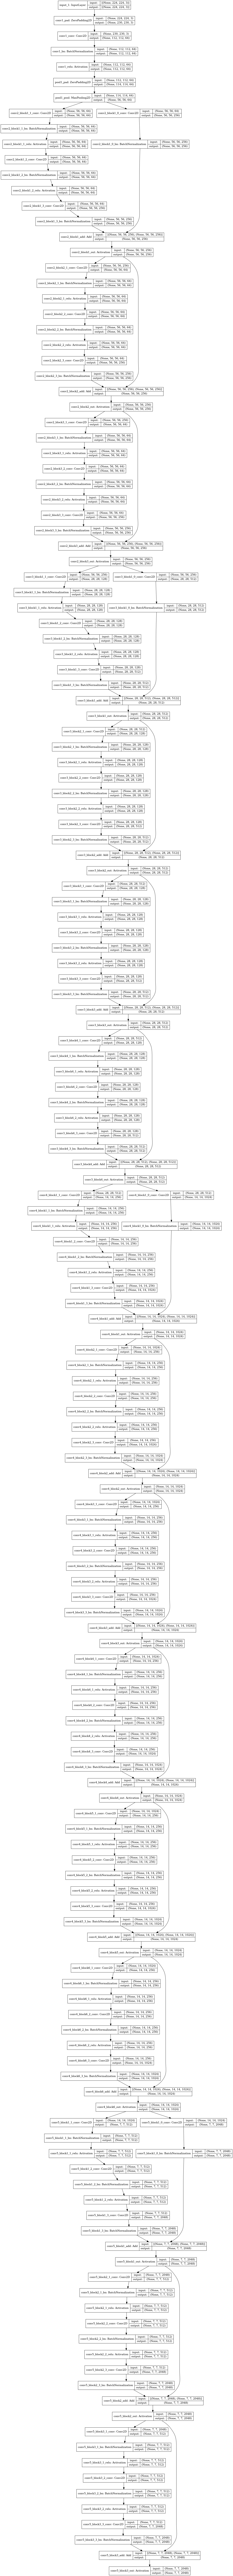

In [5]:
keras.utils.plot_model(resnet50_net, show_shapes=True)

In [6]:
def get_tabular_model(inputs):
    activation = "relu"
    kernel_regularizer = keras.regularizers.l2()
    x = keras.layers.Dense(12, activation=activation, kernel_regularizer = keras.regularizers.l2())(inputs)
    x = keras.layers.Dense(64, activation=activation,kernel_regularizer = keras.regularizers.l2())(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation=activation,kernel_regularizer = keras.regularizers.l2())(x)
    x = keras.layers.Dense(64, activation=activation,kernel_regularizer = keras.regularizers.l2())(x)
    x = keras.layers.Concatenate()([x, inputs])
    return x

In [7]:
def get_model():
    image_inputs = tf.keras.Input((image_size, image_size , 3))
    tabular_inputs = tf.keras.Input(len(tabular_columns))
    image_x = resnet50_net(image_inputs)
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)
    #for _ in range(1):
    #    image_x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2())(image_x)
    image_x = tf.keras.layers.Dropout(0.5)(image_x)
    tabular_x = get_tabular_model(tabular_inputs)
    x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

In [8]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [9]:
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[tabular_columns])).map(preprocess_test_data).batch(batch_size).cache().prefetch(2)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


In [10]:
total_results = []

for i in [0, 1, 2, 4]:
    model = get_model()
    model.load_weights("../input/resnet50ver1/model_%d.h5"%(i))
    results = model.predict(test_ds).reshape(-1)
    total_results.append(results)
    
results = np.mean(total_results, axis=0).reshape(-1)
sample_submission["Pawpularity"] = results
sample_submission.to_csv("submission.csv", index=False)

2021-12-31 10:34:31.197451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
sample_submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,35.382908
1,43a2262d7738e3d420d453815151079e,31.554552
2,4e429cead1848a298432a0acad014c9d,32.304871
3,80bc3ccafcc51b66303c2c263aa38486,28.273117
4,8f49844c382931444e68dffbe20228f4,27.106449
5,b03f7041962238a7c9d6537e22f9b017,33.563454
6,c978013571258ed6d4637f6e8cc9d6a3,26.027061
7,e0de453c1bffc20c22b072b34b54e50f,30.606808
